In [1]:
import re
import numpy as np
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time
import malaya

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
tokenizer = malaya.preprocessing._SocialTokenizer().tokenize
rules_normalizer = malaya.texts._tatabahasa.rules_normalizer

def is_number_regex(s):
    if re.match("^\d+?\.\d+?$", s) is None:
        return s.isdigit()
    return True

def detect_money(word):
    if word[:2] == 'rm' and is_number_regex(word[2:]):
        return True
    else:
        return False

def preprocessing(string):
    tokenized = tokenizer(unidecode(string))
    tokenized = [malaya.stem.naive(w) for w in tokenized]
    tokenized = [w.lower() for w in tokenized if len(w) > 1]
    tokenized = [rules_normalizer.get(w, w) for w in tokenized]
    tokenized = ['<NUM>' if is_number_regex(w) else w for w in tokenized]
    tokenized = ['<MONEY>' if detect_money(w) else w for w in tokenized]
    return tokenized

In [3]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen][::-1]):
            X[i, -1 - no] = dic.get(k, UNK)
    return X

In [4]:
preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya jd')

['raja',
 'benar',
 'sangat',
 'benci',
 'rakyat',
 'minyak',
 'naik',
 'gala',
 'jadi']

In [5]:
import json

with open('tokenization.json') as fopen:
    dataset = json.load(fopen)
texts = dataset['texts']
labels = dataset['labels']
del dataset

In [6]:
with open('sentiment-dictionary.json') as fopen:
    d = json.load(fopen)
dictionary = d['dictionary']
rev_dictionary = d['reverse_dictionary']

In [7]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def Attention(inputs, num_units, num_heads = 8, activation = None):
    inputs = tf.layers.dropout(inputs, 0.3, training=True)
    T_q = T_k = tf.shape(inputs)[1]
    Q_K_V = tf.layers.dense(inputs, 3*num_units, activation)
    Q, K, V = tf.split(Q_K_V, 3, -1)
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), 0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), 0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), 0)
    align = tf.matmul(Q_, K_, transpose_b=True)
    align *= tf.rsqrt(tf.to_float(K_.get_shape()[-1].value))
    paddings = tf.fill(tf.shape(align), float('-inf'))
    lower_tri = tf.ones([T_q, T_k])
    lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
    masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0],1,1])
    align = tf.where(tf.equal(masks, 0), paddings, align)
    align = tf.nn.softmax(align)
    alignments = tf.transpose(align, [0, 2, 1]) 
    x = tf.matmul(align, V_)
    x = tf.concat(tf.split(x, num_heads, axis=0), 2)
    x += inputs
    x = layer_norm(x)
    return x, alignments

class Model:
    def __init__(self, size_layer, embed_size, dict_size, dimension_output, learning_rate = 1e-3):
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        
        encoder_embeddings = tf.Variable(tf.random_uniform([dict_size, embed_size], -1, 1))
        x = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        x += position_encoding(x)
        x = tf.layers.dropout(x, 0.3, training=True) 
        
        x, self.alignments = Attention(x, size_layer)
        self.logits_seq = tf.layers.dense(x, dimension_output)
        self.logits_seq = tf.identity(self.logits_seq, name = 'logits_seq')
        self.logits = self.logits_seq[:,-1]
        self.logits = tf.identity(self.logits, name = 'logits')

        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.identity(tf.reduce_mean(self.alignments[0], 1), name = 'alphas')

In [8]:
size_layer = 256
dimension_output = 2
learning_rate = 1e-4
batch_size = 32
maxlen = 100

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    size_layer,
    len(dictionary),
    dimension_output,
    learning_rate,
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [9]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and '_power' not in n.name
    ]
)

In [10]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'dense/kernel',
 'dense/bias',
 'gamma',
 'beta',
 'dense_1/kernel',
 'dense_1/bias',
 'logits_seq',
 'logits',
 'alphas']

In [11]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(124794, 256) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(256, 768) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(768,) dtype=float32_ref>,
 <tf.Variable 'gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(256, 2) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32_ref>]

In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(
    texts, labels, test_size = 0.2
)

In [13]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = str_idx(train_X[i : min(i + batch_size, len(train_X))], dictionary, maxlen)
        batch_y = train_Y[i : min(i + batch_size, len(train_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
        batch_y = test_Y[i : min(i + batch_size, len(test_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1

train minibatch loop:   0%|          | 3/16876 [00:00<13:58, 20.12it/s, accuracy=0.594, cost=0.601]

epoch: 0, pass acc: 0.000000, current acc: 0.715723
time taken: 873.6518127918243
epoch: 0, training loss: 0.595912, training acc: 0.675681, valid loss: 0.551319, valid acc: 0.715723



train minibatch loop:   0%|          | 3/16876 [00:00<14:01, 20.06it/s, accuracy=0.719, cost=0.49] 

epoch: 1, pass acc: 0.715723, current acc: 0.737070
time taken: 872.8621339797974
epoch: 1, training loss: 0.538746, training acc: 0.726348, valid loss: 0.524194, valid acc: 0.737070



train minibatch loop:   0%|          | 3/16876 [00:00<13:59, 20.10it/s, accuracy=0.75, cost=0.524] 

epoch: 2, pass acc: 0.737070, current acc: 0.747819
time taken: 872.872700214386
epoch: 2, training loss: 0.516308, training acc: 0.743540, valid loss: 0.508608, valid acc: 0.747819



train minibatch loop:   0%|          | 2/16876 [00:00<14:38, 19.22it/s, accuracy=0.906, cost=0.394]

epoch: 3, pass acc: 0.747819, current acc: 0.753670
time taken: 872.786773443222
epoch: 3, training loss: 0.503027, training acc: 0.753103, valid loss: 0.500447, valid acc: 0.753670



train minibatch loop:   0%|          | 3/16876 [00:00<13:56, 20.17it/s, accuracy=0.844, cost=0.389]

epoch: 4, pass acc: 0.753670, current acc: 0.759175
time taken: 872.8474028110504
epoch: 4, training loss: 0.494213, training acc: 0.759081, valid loss: 0.493601, valid acc: 0.759175



train minibatch loop:   0%|          | 3/16876 [00:00<13:58, 20.12it/s, accuracy=0.75, cost=0.478] 

epoch: 5, pass acc: 0.759175, current acc: 0.763107
time taken: 873.0266923904419
epoch: 5, training loss: 0.487159, training acc: 0.764167, valid loss: 0.487517, valid acc: 0.763107



train minibatch loop:   0%|          | 3/16876 [00:00<13:58, 20.13it/s, accuracy=0.906, cost=0.404]

epoch: 6, pass acc: 0.763107, current acc: 0.764522
time taken: 872.9059422016144
epoch: 6, training loss: 0.481288, training acc: 0.767570, valid loss: 0.484200, valid acc: 0.764522



train minibatch loop:   0%|          | 3/16876 [00:00<13:57, 20.14it/s, accuracy=0.75, cost=0.421] 

epoch: 7, pass acc: 0.764522, current acc: 0.768298
time taken: 872.9461388587952
epoch: 7, training loss: 0.476970, training acc: 0.770630, valid loss: 0.480285, valid acc: 0.768298



train minibatch loop:   0%|          | 3/16876 [00:00<13:56, 20.18it/s, accuracy=0.812, cost=0.419]

epoch: 8, pass acc: 0.768298, current acc: 0.769396
time taken: 873.0376634597778
epoch: 8, training loss: 0.473226, training acc: 0.772856, valid loss: 0.477995, valid acc: 0.769396



train minibatch loop:   0%|          | 3/16876 [00:00<14:00, 20.08it/s, accuracy=0.875, cost=0.35]

epoch: 9, pass acc: 0.769396, current acc: 0.770027
time taken: 873.0693907737732
epoch: 9, training loss: 0.469894, training acc: 0.774875, valid loss: 0.475846, valid acc: 0.770027



train minibatch loop:   0%|          | 3/16876 [00:00<13:55, 20.19it/s, accuracy=0.844, cost=0.391]

epoch: 10, pass acc: 0.770027, current acc: 0.770912
time taken: 873.1026468276978
epoch: 10, training loss: 0.466412, training acc: 0.777606, valid loss: 0.474340, valid acc: 0.770912



train minibatch loop:   0%|          | 3/16876 [00:00<13:54, 20.23it/s, accuracy=0.812, cost=0.41] 

epoch: 11, pass acc: 0.770912, current acc: 0.771190
time taken: 873.1505410671234
epoch: 11, training loss: 0.463504, training acc: 0.779456, valid loss: 0.474276, valid acc: 0.771190



train minibatch loop:   0%|          | 3/16876 [00:00<13:55, 20.20it/s, accuracy=0.812, cost=0.437]

epoch: 12, pass acc: 0.771190, current acc: 0.773262
time taken: 873.0738255977631
epoch: 12, training loss: 0.461311, training acc: 0.780315, valid loss: 0.471637, valid acc: 0.773262



train minibatch loop:   0%|          | 3/16876 [00:00<13:55, 20.21it/s, accuracy=0.812, cost=0.389]

epoch: 13, pass acc: 0.773262, current acc: 0.774974
time taken: 873.0719096660614
epoch: 13, training loss: 0.458761, training acc: 0.782322, valid loss: 0.469102, valid acc: 0.774974



train minibatch loop:   0%|          | 3/16876 [00:00<13:56, 20.18it/s, accuracy=0.781, cost=0.448]

time taken: 873.2016248703003
epoch: 14, training loss: 0.456533, training acc: 0.783382, valid loss: 0.469040, valid acc: 0.773382



train minibatch loop:   0%|          | 3/16876 [00:00<13:53, 20.24it/s, accuracy=0.75, cost=0.446] 

epoch: 15, pass acc: 0.774974, current acc: 0.775913
time taken: 873.0704691410065
epoch: 15, training loss: 0.453938, training acc: 0.784770, valid loss: 0.468686, valid acc: 0.775913



train minibatch loop:   0%|          | 3/16876 [00:00<13:55, 20.20it/s, accuracy=0.844, cost=0.366]

time taken: 873.0411856174469
epoch: 16, training loss: 0.452284, training acc: 0.786289, valid loss: 0.466593, valid acc: 0.775839



train minibatch loop:   0%|          | 2/16876 [00:00<14:11, 19.81it/s, accuracy=0.844, cost=0.343]

epoch: 17, pass acc: 0.775913, current acc: 0.776062
time taken: 873.122752904892
epoch: 17, training loss: 0.451134, training acc: 0.786990, valid loss: 0.467707, valid acc: 0.776062



train minibatch loop:   0%|          | 3/16876 [00:00<13:55, 20.19it/s, accuracy=0.844, cost=0.364]

epoch: 18, pass acc: 0.776062, current acc: 0.776773
time taken: 873.0830545425415
epoch: 18, training loss: 0.448639, training acc: 0.788359, valid loss: 0.467222, valid acc: 0.776773



train minibatch loop:   0%|          | 3/16876 [00:00<13:54, 20.21it/s, accuracy=0.938, cost=0.347]

epoch: 19, pass acc: 0.776773, current acc: 0.776832
time taken: 873.164381980896
epoch: 19, training loss: 0.447150, training acc: 0.789168, valid loss: 0.466600, valid acc: 0.776832



train minibatch loop:   0%|          | 3/16876 [00:00<13:59, 20.09it/s, accuracy=0.812, cost=0.388]

epoch: 20, pass acc: 0.776832, current acc: 0.777884
time taken: 873.1035535335541
epoch: 20, training loss: 0.445555, training acc: 0.790610, valid loss: 0.465082, valid acc: 0.777884



train minibatch loop:   0%|          | 3/16876 [00:00<13:54, 20.21it/s, accuracy=0.812, cost=0.429]

time taken: 873.0824906826019
epoch: 21, training loss: 0.444026, training acc: 0.791076, valid loss: 0.464617, valid acc: 0.777632



train minibatch loop:   0%|          | 3/16876 [00:00<13:55, 20.19it/s, accuracy=0.844, cost=0.366]

epoch: 22, pass acc: 0.777884, current acc: 0.778025
time taken: 873.1131408214569
epoch: 22, training loss: 0.442452, training acc: 0.791935, valid loss: 0.464123, valid acc: 0.778025



train minibatch loop:   0%|          | 3/16876 [00:00<13:59, 20.11it/s, accuracy=0.781, cost=0.428]

epoch: 23, pass acc: 0.778025, current acc: 0.778756
time taken: 873.0947358608246
epoch: 23, training loss: 0.441143, training acc: 0.792680, valid loss: 0.463258, valid acc: 0.778756



train minibatch loop:   0%|          | 3/16876 [00:00<13:55, 20.19it/s, accuracy=0.875, cost=0.367]

epoch: 24, pass acc: 0.778756, current acc: 0.778967
time taken: 873.1105782985687
epoch: 24, training loss: 0.439897, training acc: 0.793989, valid loss: 0.462837, valid acc: 0.778967



train minibatch loop:   0%|          | 3/16876 [00:00<14:02, 20.03it/s, accuracy=0.844, cost=0.428]

time taken: 873.0930559635162
epoch: 25, training loss: 0.438801, training acc: 0.794719, valid loss: 0.463401, valid acc: 0.778084



test minibatch loop:  51%|█████     | 2152/4219 [00:18<00:17, 118.44it/s, accuracy=0.812, cost=0.469]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train minibatch loop:  67%|██████▋   | 11315/16876 [09:21<04:35, 20.15it/s, accuracy=0.781, cost=0.481]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

test minibatch loop:  99%|█████████▉| 4176/4219 [00:34<00:00, 120.00it/s, accuracy=0.875, cost=0.301]IOPub message rate exceeded.
The notebook ser

In [14]:
saver.save(sess, 'only-attention/model.ckpt')

'only-attention/model.ckpt'

In [15]:
text = preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text], dictionary, len(text))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.83869356, 0.16130647]], dtype=float32)

In [18]:
text = preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text], dictionary, len(text))
sess.run([tf.nn.softmax(model.logits_seq), model.attention], feed_dict={model.X:new_vector})

[array([[[0.04035725, 0.95964277],
         [0.3335168 , 0.66648316],
         [0.5767256 , 0.42327443],
         [0.988713  , 0.01128694],
         [0.8683654 , 0.13163453],
         [0.867992  , 0.13200802],
         [0.99281424, 0.00718583],
         [0.9350784 , 0.06492158]]], dtype=float32),
 array([2.8282857e-01, 5.0085597e-02, 1.7758933e-01, 4.7541022e-01,
        7.7311522e-03, 1.9795415e-03, 3.9819553e-03, 3.9367162e-04],
       dtype=float32)]

In [19]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
    batch_y = test_Y[i : min(i + batch_size, len(test_X))]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y

validation minibatch loop: 100%|██████████| 4219/4219 [00:30<00:00, 139.05it/s]


In [20]:
print(
    metrics.classification_report(
        real_Y, predict_Y, target_names = ['negative', 'positive']
    )
)

             precision    recall  f1-score   support

   negative       0.77      0.82      0.80     70708
   positive       0.79      0.74      0.76     64297

avg / total       0.78      0.78      0.78    135005



In [21]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [22]:
freeze_graph('only-attention', strings)

INFO:tensorflow:Restoring parameters from only-attention/model.ckpt
INFO:tensorflow:Froze 7 variables.
INFO:tensorflow:Converted 7 variables to const ops.
248 ops in the final graph.


In [23]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [25]:
g = load_graph('only-attention/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits_seq = g.get_tensor_by_name('import/logits_seq:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas, logits_seq], feed_dict = {x: new_vector})

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [28]:
news_string = 'Kerajaan juga perlu prihatin dan peka terhadap nasib para nelayan yang bergantung rezeki sepenuhnya kepada sumber hasil laut. Malah, projek ini memberikan kesan buruk yang berpanjangan kepada alam sekitar selain menjejaskan mata pencarian para nelayan'

In [29]:
text = preprocessing(news_string)
new_vector = str_idx([text], dictionary, len(text))
result = test_sess.run([tf.nn.softmax(logits), alphas, tf.nn.softmax(logits_seq)], feed_dict = {x: new_vector})

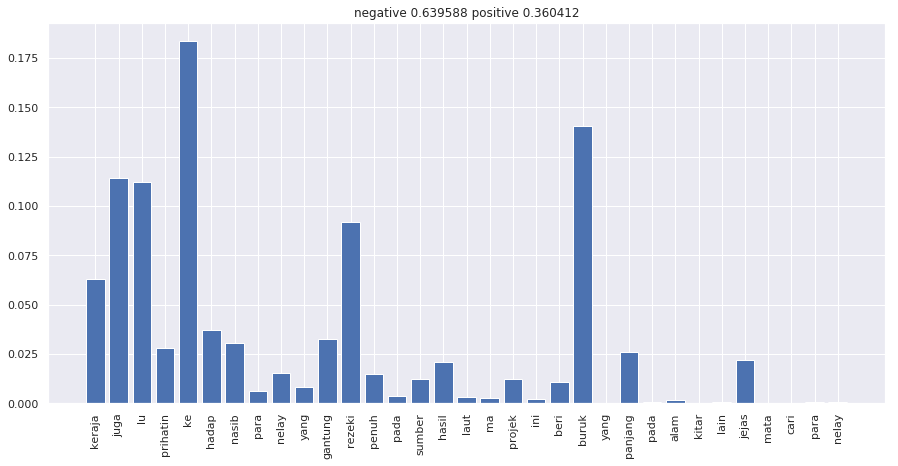

In [30]:
plt.figure(figsize = (15, 7))
labels = [word for word in text]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.title('negative %f positive %f' % (result[0][0,0], result[0][0,1]))
plt.show()